# ACTIVIDAD DE CLASIFICACIÓN DE TEXTO

En esta actividad vamos a trabajar en clasificar textos. Se recorrerá todo el proceso desde traer el dataset hasta proceder a dicha clasificación. Durante la actividad se llevarán a cabo muchos procesos como la creación de un vocabulario, el uso de embeddings y la creación de modelos.

Las cuestiones presentes en esta actividad están basadas en un Notebook creado por François Chollet, uno de los creadores de Keras y autor del libro "Deep Learning with Python".

En este Notebook se trabaja con el dataset "Newsgroup20" que contiene aproximadamente 20000 mensajes que pertenecen a 20 categorías diferentes.

El objetivo es entender los conceptos que se trabajan y ser capaz de hacer pequeñas experimentaciones para mejorar el Notebook creado.

# Librerías

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

2025-02-05 21:32:38.683520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Descarga de Datos

In [2]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pathlib

#Estructura de directorios del dataset
data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

Number of directories: 20
Directory names: ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']


In [4]:
print(data_dir)

/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup


In [5]:
#Algunos archivos de la categoria "com.graphics"
fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of files in comp.graphics: 1000
Some example filenames: ['38254', '38402', '38630', '38865', '38891']


In [6]:
#Ejemplo de un texto de la categoría "com.graphics"
print(open(data_dir / "comp.graphics" / "37261").read())

Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:37261 alt.graphics:519 comp.graphics.animation:2614
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!zaphod.mps.ohio-state.edu!darwin.sura.net!dtix.dt.navy.mil!oasys!lipman
From: lipman@oasys.dt.navy.mil (Robert Lipman)
Newsgroups: comp.graphics,alt.graphics,comp.graphics.animation
Subject: CALL FOR PRESENTATIONS: Navy SciViz/VR Seminar
Message-ID: <32850@oasys.dt.navy.mil>
Date: 19 Mar 93 20:10:23 GMT
Article-I.D.: oasys.32850
Expires: 30 Apr 93 04:00:00 GMT
Reply-To: lipman@oasys.dt.navy.mil (Robert Lipman)
Followup-To: comp.graphics
Distribution: usa
Organization: Carderock Division, NSWC, Bethesda, MD
Lines: 65


			CALL FOR PRESENTATIONS
	
      NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR

			Tuesday, June 22, 1993

	    Carderock Division, Naval Surface Warfare Center
	      (formerly the David Taylor Research Center)
			  Bethesda, Maryland

SPONSOR: NESS (Navy Engineering Software System) is sponsori

In [7]:
#Algunos archivos de la categoria "talk.politics.misc"
fnames = os.listdir(data_dir / "talk.politics.misc")
print("Number of files in talk.politics.misc:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of files in talk.politics.misc: 1000
Some example filenames: ['178529', '178971', '178985', '178340', '178516']


In [8]:
#Ejemplo de un texto de la categoría "talk.politics.misc"
print(open(data_dir / "talk.politics.misc" / "178463").read())

Xref: cantaloupe.srv.cs.cmu.edu talk.politics.guns:54219 talk.politics.misc:178463
Newsgroups: talk.politics.guns,talk.politics.misc
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!darwin.sura.net!martha.utcc.utk.edu!FRANKENSTEIN.CE.UTK.EDU!VEAL
From: VEAL@utkvm1.utk.edu (David Veal)
Subject: Re: Proof of the Viability of Gun Control
Message-ID: <VEAL.749.735192116@utkvm1.utk.edu>
Lines: 21
Sender: usenet@martha.utcc.utk.edu (USENET News System)
Organization: University of Tennessee Division of Continuing Education
References: <1qpbqd$ntl@access.digex.net> <C5otvp.ItL@magpie.linknet.com>
Date: Mon, 19 Apr 1993 04:01:56 GMT

[alt.drugs and alt.conspiracy removed from newsgroups line.]

In article <C5otvp.ItL@magpie.linknet.com> neal@magpie.linknet.com (Neal) writes:

>   Once the National Guard has been called into federal service,
>it is under the command of the present. Tha N

In [9]:
list_all_dir = [
    'alt.atheism',
    'comp.graphics',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.misc',
    'talk.religion.misc'
]

In [10]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in list_all_dir:
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.misc', 'talk.religion.misc']
Number of samples: 14997


# Mezclando los datos para separarlos en Traning y Test

In [11]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)
keras.utils.set_random_seed(seed)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

# Tokenización de las palabras con TextVectorization

In [12]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

2025-02-05 21:33:08.686074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'to', 'of']

In [14]:
len(vectorizer.get_vocabulary())

20000

# Viendo la salida de Vectorizer

In [15]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   2, 3844, 2060,   18,    2, 4807])

In [16]:
output

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[   2, 3844, 2060,   18,    2, 4807,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [17]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [18]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 3844, 2060, 18, 2, 4807]

# Tokenización de los datos de entrenamiento y validación

In [19]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

# Creación y entrenamiento del modelo. Transformers

In [20]:
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [21]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
num_tokens = len(voc) + 2

maxlen = 200
vocab_size = num_tokens

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False)
#x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

modeloTransformers = keras.Model(inputs=inputs, outputs=outputs)


In [23]:
modeloTransformers.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
modeloTransformers.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))
print(modeloTransformers.summary())

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 548ms/step - acc: 0.1011 - loss: 2.6764 - val_acc: 0.2031 - val_loss: 2.4753
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - acc: 0.2110 - loss: 2.4010 - val_acc: 0.2971 - val_loss: 2.1453
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - acc: 0.3258 - loss: 2.0869 - val_acc: 0.3328 - val_loss: 2.2462
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - acc: 0.4242 - loss: 1.8045 - val_acc: 0.5955 - val_loss: 1.4052
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - acc: 0.5396 - loss: 1.4310 - val_acc: 0.6139 - val_loss: 1.1653
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 306ms/step - acc: 0.6984 - loss: 0.9663 - val_acc: 0.7669 - val_loss: 0.7460
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 326ms/step - acc: 0.7877 - loss: 0.6662 - val_acc: 0.7649 - val_loss: 0.7232
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - acc: 0.8386 - loss: 0.5022 - val_acc: 0.7696 - val_loss: 0.7102
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 366ms/

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 200, 32)        │       646,464 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,192 (5.02 MB)

 Trainable params: 658,095 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 658,097 (2.51 MB)

None


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step
Classification Report:
                        precision    recall  f1-score   support

           alt.atheism       0.69      0.76      0.72       220
         comp.graphics       0.79      0.87      0.83       188
 comp.sys.mac.hardware       0.94      0.79      0.86       218
        comp.windows.x       0.88      0.88      0.88       200
          misc.forsale       0.79      0.86      0.82       194
             rec.autos       0.93      0.88      0.90       216
    rec.sport.baseball       0.83      0.92      0.87       189
      rec.sport.hockey       0.94      0.94      0.94       203
             sci.crypt       0.91      0.90      0.90       194
               sci.med       0.95      0.90      0.92       211
             sci.space       0.94      0.91      0.92       193
soc.religion.christian       0.81      0.94      0.87       196
    talk.politics.guns       0.80      0.76      0.78       191
    talk.politics.misc       0.75      0

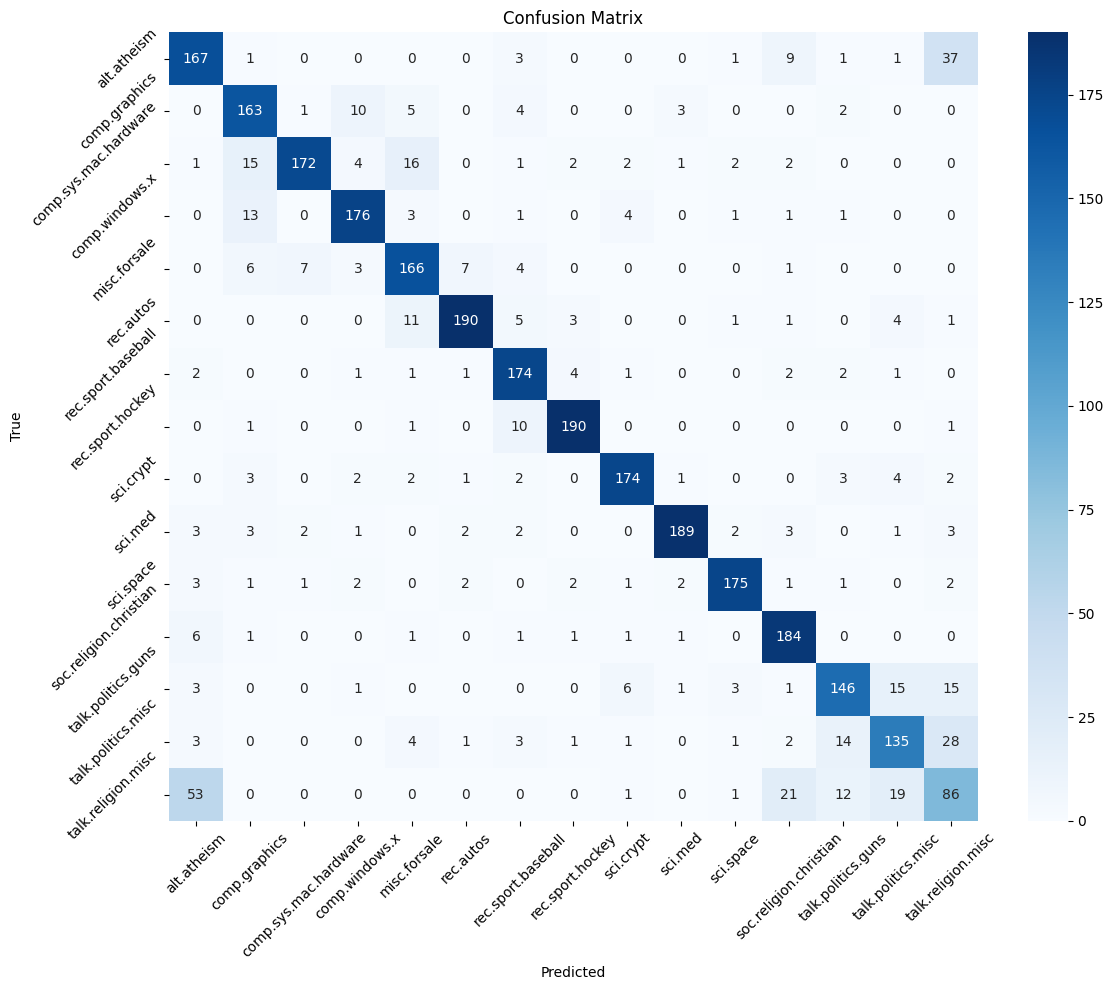

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

# Get predictions on validation set
y_pred = modeloTransformers.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluación

In [24]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = modeloTransformers(x)
end_to_end_model = keras.Model(string_input, preds)

In [25]:
probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["this message is about computer graphics and 3D modeling"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

comp.graphics


In [26]:
probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["politics and federal courts law that people understand with politician and elects congressman"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

talk.politics.misc


In [27]:
probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["we are talking about religion"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

alt.atheism
